In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

# Parameters
model_name = 'meta-llama/Meta-Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_70B.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_70B.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2500, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 198/198 [00:30<00:00,  6.44it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 198/198 [00:02<00:00, 97.41it/s] 


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 184/184 [00:27<00:00,  6.75it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 184/184 [00:01<00:00, 101.03it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 10/2500 [00:00<03:10, 13.09it/s]

Epoch 10/2500, Loss: 0.3842
Test Accuracy at Epoch 10: 85.90%
Test F1-score at Epoch 10: 0.8761
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.95      0.75      0.84       147
non_infringement       0.80      0.96      0.88       158

        accuracy                           0.86       305
       macro avg       0.88      0.86      0.86       305
    weighted avg       0.87      0.86      0.86       305

New best model saved with F1-score 0.8761 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.95      0.75      0.84       147
non_infringement       0.80      0.96      0.88       158

        accuracy                           0.86       305
       macro avg       0.88      0.86      0.86       305
    weighted avg       0.87      0.86      0.86       305



Training Epochs:   1%|          | 24/2500 [00:01<01:39, 24.83it/s]

Epoch 20/2500, Loss: 0.3144
Test Accuracy at Epoch 20: 85.57%
Test F1-score at Epoch 20: 0.8728
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.94      0.75      0.83       147
non_infringement       0.80      0.96      0.87       158

        accuracy                           0.86       305
       macro avg       0.87      0.85      0.85       305
    weighted avg       0.87      0.86      0.85       305



Training Epochs:   1%|          | 31/2500 [00:01<01:46, 23.13it/s]

Epoch 30/2500, Loss: 0.2366
Test Accuracy at Epoch 30: 87.87%
Test F1-score at Epoch 30: 0.8862
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.90      0.84      0.87       147
non_infringement       0.86      0.91      0.89       158

        accuracy                           0.88       305
       macro avg       0.88      0.88      0.88       305
    weighted avg       0.88      0.88      0.88       305

New best model saved with F1-score 0.8862 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.90      0.84      0.87       147
non_infringement       0.86      0.91      0.89       158

        accuracy                           0.88       305
       macro avg       0.88      0.88      0.88       305
    weighted avg       0.88      0.88      0.88       305



Training Epochs:   2%|▏         | 44/2500 [00:02<01:49, 22.49it/s]

Epoch 40/2500, Loss: 0.1787
Test Accuracy at Epoch 40: 89.18%
Test F1-score at Epoch 40: 0.8991
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.92      0.85      0.88       147
non_infringement       0.87      0.93      0.90       158

        accuracy                           0.89       305
       macro avg       0.89      0.89      0.89       305
    weighted avg       0.89      0.89      0.89       305

New best model saved with F1-score 0.8991 at epoch 40
Best Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.92      0.85      0.88       147
non_infringement       0.87      0.93      0.90       158

        accuracy                           0.89       305
       macro avg       0.89      0.89      0.89       305
    weighted avg       0.89      0.89      0.89       305



Training Epochs:   2%|▏         | 53/2500 [00:02<01:45, 23.30it/s]

Epoch 50/2500, Loss: 0.1321
Test Accuracy at Epoch 50: 90.82%
Test F1-score at Epoch 50: 0.9157
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.95      0.85      0.90       147
non_infringement       0.87      0.96      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

New best model saved with F1-score 0.9157 at epoch 50
Best Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.95      0.85      0.90       147
non_infringement       0.87      0.96      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:   2%|▏         | 61/2500 [00:03<01:29, 27.33it/s]

Epoch 60/2500, Loss: 0.0985
Test Accuracy at Epoch 60: 90.49%
Test F1-score at Epoch 60: 0.9108
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.93      0.87      0.90       147
non_infringement       0.89      0.94      0.91       158

        accuracy                           0.90       305
       macro avg       0.91      0.90      0.90       305
    weighted avg       0.91      0.90      0.90       305



Training Epochs:   3%|▎         | 72/2500 [00:03<01:37, 24.85it/s]

Epoch 70/2500, Loss: 0.0751
Test Accuracy at Epoch 70: 91.15%
Test F1-score at Epoch 70: 0.9189
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.96      0.85      0.90       147
non_infringement       0.87      0.97      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.92      0.91      0.91       305

New best model saved with F1-score 0.9189 at epoch 70
Best Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.96      0.85      0.90       147
non_infringement       0.87      0.97      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.92      0.91      0.91       305



Training Epochs:   3%|▎         | 82/2500 [00:04<02:17, 17.63it/s]

Epoch 80/2500, Loss: 0.0596
Test Accuracy at Epoch 80: 92.46%
Test F1-score at Epoch 80: 0.9305
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.97      0.87      0.92       147
non_infringement       0.89      0.97      0.93       158

        accuracy                           0.92       305
       macro avg       0.93      0.92      0.92       305
    weighted avg       0.93      0.92      0.92       305

New best model saved with F1-score 0.9305 at epoch 80
Best Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.97      0.87      0.92       147
non_infringement       0.89      0.97      0.93       158

        accuracy                           0.92       305
       macro avg       0.93      0.92      0.92       305
    weighted avg       0.93      0.92      0.92       305



Training Epochs:   4%|▍         | 97/2500 [00:04<01:37, 24.62it/s]

Epoch 90/2500, Loss: 0.0492
Test Accuracy at Epoch 90: 92.46%
Test F1-score at Epoch 90: 0.9305
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.97      0.87      0.92       147
non_infringement       0.89      0.97      0.93       158

        accuracy                           0.92       305
       macro avg       0.93      0.92      0.92       305
    weighted avg       0.93      0.92      0.92       305



Training Epochs:   4%|▍         | 105/2500 [00:05<01:23, 28.84it/s]

Epoch 100/2500, Loss: 0.0419
Test Accuracy at Epoch 100: 92.79%
Test F1-score at Epoch 100: 0.9333
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305

New best model saved with F1-score 0.9333 at epoch 100
Best Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:   5%|▍         | 115/2500 [00:05<01:09, 34.18it/s]

Epoch 110/2500, Loss: 0.0361
Test Accuracy at Epoch 110: 92.79%
Test F1-score at Epoch 110: 0.9333
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:   5%|▌         | 125/2500 [00:05<01:03, 37.51it/s]

Epoch 120/2500, Loss: 0.0315
Test Accuracy at Epoch 120: 92.79%
Test F1-score at Epoch 120: 0.9333
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.97      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:   5%|▌         | 135/2500 [00:05<01:00, 39.14it/s]

Epoch 130/2500, Loss: 0.0280
Test Accuracy at Epoch 130: 92.79%
Test F1-score at Epoch 130: 0.9329
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.96      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:   6%|▌         | 145/2500 [00:06<00:58, 40.26it/s]

Epoch 140/2500, Loss: 0.0255
Test Accuracy at Epoch 140: 92.79%
Test F1-score at Epoch 140: 0.9329
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.96      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:   6%|▌         | 150/2500 [00:06<00:59, 39.79it/s]

Epoch 150/2500, Loss: 0.0236
Test Accuracy at Epoch 150: 92.46%
Test F1-score at Epoch 150: 0.9297
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.96      0.88      0.92       147
non_infringement       0.90      0.96      0.93       158

        accuracy                           0.92       305
       macro avg       0.93      0.92      0.92       305
    weighted avg       0.93      0.92      0.92       305



Training Epochs:   7%|▋         | 166/2500 [00:07<01:28, 26.40it/s]

Epoch 160/2500, Loss: 0.0221
Test Accuracy at Epoch 160: 92.79%
Test F1-score at Epoch 160: 0.9329
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.96      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:   7%|▋         | 174/2500 [00:07<01:18, 29.76it/s]

Epoch 170/2500, Loss: 0.0208
Test Accuracy at Epoch 170: 92.79%
Test F1-score at Epoch 170: 0.9329
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.96      0.88      0.92       147
non_infringement       0.90      0.97      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:   7%|▋         | 186/2500 [00:08<01:41, 22.85it/s]

Epoch 180/2500, Loss: 0.0197
Test Accuracy at Epoch 180: 92.46%
Test F1-score at Epoch 180: 0.9297
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.96      0.88      0.92       147
non_infringement       0.90      0.96      0.93       158

        accuracy                           0.92       305
       macro avg       0.93      0.92      0.92       305
    weighted avg       0.93      0.92      0.92       305



Training Epochs:   8%|▊         | 194/2500 [00:08<01:24, 27.16it/s]

Epoch 190/2500, Loss: 0.0185
Test Accuracy at Epoch 190: 92.13%
Test F1-score at Epoch 190: 0.9264
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.95      0.88      0.92       147
non_infringement       0.90      0.96      0.93       158

        accuracy                           0.92       305
       macro avg       0.92      0.92      0.92       305
    weighted avg       0.92      0.92      0.92       305



Training Epochs:   8%|▊         | 203/2500 [00:08<01:15, 30.24it/s]

Epoch 200/2500, Loss: 0.0203
Test Accuracy at Epoch 200: 94.75%
Test F1-score at Epoch 200: 0.9490
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305

New best model saved with F1-score 0.9490 at epoch 200
Best Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:   9%|▊         | 216/2500 [00:08<01:10, 32.44it/s]

Epoch 210/2500, Loss: 0.0196
Test Accuracy at Epoch 210: 95.41%
Test F1-score at Epoch 210: 0.9557
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.95      0.95      0.95       147
non_infringement       0.96      0.96      0.96       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305

New best model saved with F1-score 0.9557 at epoch 210
Best Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.95      0.95      0.95       147
non_infringement       0.96      0.96      0.96       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:   9%|▉         | 224/2500 [00:09<01:05, 34.85it/s]

Epoch 220/2500, Loss: 0.0186
Test Accuracy at Epoch 220: 95.08%
Test F1-score at Epoch 220: 0.9524
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.95      0.95      0.95       147
non_infringement       0.96      0.95      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:   9%|▉         | 237/2500 [00:09<01:00, 37.52it/s]

Epoch 230/2500, Loss: 0.0178
Test Accuracy at Epoch 230: 94.75%
Test F1-score at Epoch 230: 0.9490
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  10%|▉         | 246/2500 [00:09<00:57, 39.30it/s]

Epoch 240/2500, Loss: 0.0173
Test Accuracy at Epoch 240: 94.75%
Test F1-score at Epoch 240: 0.9490
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  10%|█         | 250/2500 [00:09<00:57, 38.91it/s]

Epoch 250/2500, Loss: 0.0168
Test Accuracy at Epoch 250: 94.75%
Test F1-score at Epoch 250: 0.9490
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  11%|█         | 264/2500 [00:10<01:58, 18.80it/s]

Epoch 260/2500, Loss: 0.0164
Test Accuracy at Epoch 260: 94.75%
Test F1-score at Epoch 260: 0.9490
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  11%|█         | 277/2500 [00:11<01:17, 28.78it/s]

Epoch 270/2500, Loss: 0.0161
Test Accuracy at Epoch 270: 94.75%
Test F1-score at Epoch 270: 0.9490
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  11%|█▏        | 286/2500 [00:11<01:04, 34.13it/s]

Epoch 280/2500, Loss: 0.0157
Test Accuracy at Epoch 280: 94.75%
Test F1-score at Epoch 280: 0.9490
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  12%|█▏        | 294/2500 [00:11<01:11, 30.84it/s]

Epoch 290/2500, Loss: 0.0154
Test Accuracy at Epoch 290: 94.75%
Test F1-score at Epoch 290: 0.9490
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.95       147
non_infringement       0.96      0.94      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  12%|█▏        | 307/2500 [00:11<01:01, 35.73it/s]

Epoch 300/2500, Loss: 0.0151
Test Accuracy at Epoch 300: 94.43%
Test F1-score at Epoch 300: 0.9457
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  13%|█▎        | 316/2500 [00:12<01:03, 34.63it/s]

Epoch 310/2500, Loss: 0.0149
Test Accuracy at Epoch 310: 94.43%
Test F1-score at Epoch 310: 0.9457
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  13%|█▎        | 326/2500 [00:12<00:54, 39.63it/s]

Epoch 320/2500, Loss: 0.0146
Test Accuracy at Epoch 320: 94.43%
Test F1-score at Epoch 320: 0.9457
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  13%|█▎        | 336/2500 [00:12<00:50, 42.48it/s]

Epoch 330/2500, Loss: 0.0144
Test Accuracy at Epoch 330: 94.43%
Test F1-score at Epoch 330: 0.9457
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  14%|█▍        | 346/2500 [00:13<00:54, 39.29it/s]

Epoch 340/2500, Loss: 0.0142
Test Accuracy at Epoch 340: 94.43%
Test F1-score at Epoch 340: 0.9457
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  14%|█▍        | 351/2500 [00:13<00:52, 40.64it/s]

Epoch 350/2500, Loss: 0.0141
Test Accuracy at Epoch 350: 94.43%
Test F1-score at Epoch 350: 0.9457
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  15%|█▍        | 363/2500 [00:14<02:00, 17.72it/s]

Epoch 360/2500, Loss: 0.0139
Test Accuracy at Epoch 360: 94.43%
Test F1-score at Epoch 360: 0.9457
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  15%|█▌        | 377/2500 [00:14<01:10, 29.99it/s]

Epoch 370/2500, Loss: 0.0137
Test Accuracy at Epoch 370: 94.43%
Test F1-score at Epoch 370: 0.9457
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.93      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  15%|█▌        | 381/2500 [00:14<01:28, 23.96it/s]

Epoch 380/2500, Loss: 0.0135
Test Accuracy at Epoch 380: 93.77%
Test F1-score at Epoch 380: 0.9389
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.94       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  16%|█▌        | 396/2500 [00:15<01:40, 20.90it/s]

Epoch 390/2500, Loss: 0.0134
Test Accuracy at Epoch 390: 93.77%
Test F1-score at Epoch 390: 0.9389
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.94       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  16%|█▌        | 401/2500 [00:15<01:22, 25.35it/s]

Epoch 400/2500, Loss: 0.0132
Test Accuracy at Epoch 400: 93.77%
Test F1-score at Epoch 400: 0.9389
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.94       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  17%|█▋        | 417/2500 [00:16<01:31, 22.72it/s]

Epoch 410/2500, Loss: 0.0131
Test Accuracy at Epoch 410: 93.77%
Test F1-score at Epoch 410: 0.9389
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.94       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  17%|█▋        | 428/2500 [00:16<01:03, 32.73it/s]

Epoch 420/2500, Loss: 0.0130
Test Accuracy at Epoch 420: 93.77%
Test F1-score at Epoch 420: 0.9389
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.94       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  18%|█▊        | 439/2500 [00:17<00:52, 39.61it/s]

Epoch 430/2500, Loss: 0.0129
Test Accuracy at Epoch 430: 93.77%
Test F1-score at Epoch 430: 0.9389
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.94       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  18%|█▊        | 444/2500 [00:17<00:50, 40.80it/s]

Epoch 440/2500, Loss: 0.0128
Test Accuracy at Epoch 440: 93.77%
Test F1-score at Epoch 440: 0.9389
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.94       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  18%|█▊        | 455/2500 [00:17<00:47, 43.02it/s]

Epoch 450/2500, Loss: 0.0127
Test Accuracy at Epoch 450: 93.11%
Test F1-score at Epoch 450: 0.9320
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.91      0.95      0.93       147
non_infringement       0.95      0.91      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:  19%|█▊        | 466/2500 [00:17<00:44, 45.51it/s]

Epoch 460/2500, Loss: 0.0126
Test Accuracy at Epoch 460: 93.11%
Test F1-score at Epoch 460: 0.9320
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.91      0.95      0.93       147
non_infringement       0.95      0.91      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305

Epoch 470/2500, Loss: 0.0125
Test Accuracy at Epoch 470: 93.11%
Test F1-score at Epoch 470: 0.9320
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.91      0.95      0.93       147
non_infringement       0.95      0.91      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:  19%|█▉        | 481/2500 [00:19<03:02, 11.06it/s]

Epoch 480/2500, Loss: 0.0127
Test Accuracy at Epoch 480: 93.44%
Test F1-score at Epoch 480: 0.9355
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.93       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.93       305
       macro avg       0.93      0.94      0.93       305
    weighted avg       0.94      0.93      0.93       305



Training Epochs:  20%|█▉        | 491/2500 [00:20<03:12, 10.45it/s]

Epoch 490/2500, Loss: 0.0124
Test Accuracy at Epoch 490: 93.44%
Test F1-score at Epoch 490: 0.9355
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.93       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.93       305
       macro avg       0.93      0.94      0.93       305
    weighted avg       0.94      0.93      0.93       305



Training Epochs:  20%|██        | 503/2500 [00:20<01:35, 20.82it/s]

Epoch 500/2500, Loss: 0.0123
Test Accuracy at Epoch 500: 93.44%
Test F1-score at Epoch 500: 0.9355
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.92      0.95      0.93       147
non_infringement       0.95      0.92      0.94       158

        accuracy                           0.93       305
       macro avg       0.93      0.94      0.93       305
    weighted avg       0.94      0.93      0.93       305



Training Epochs:  21%|██        | 517/2500 [00:21<01:01, 32.09it/s]

Epoch 510/2500, Loss: 0.0123
Test Accuracy at Epoch 510: 93.77%
Test F1-score at Epoch 510: 0.9385
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  21%|██        | 521/2500 [00:21<01:01, 32.20it/s]

Epoch 520/2500, Loss: 0.0122
Test Accuracy at Epoch 520: 93.77%
Test F1-score at Epoch 520: 0.9385
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  21%|██▏       | 535/2500 [00:21<00:57, 33.90it/s]

Epoch 530/2500, Loss: 0.0121
Test Accuracy at Epoch 530: 93.77%
Test F1-score at Epoch 530: 0.9385
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  22%|██▏       | 545/2500 [00:21<00:49, 39.76it/s]

Epoch 540/2500, Loss: 0.0122
Test Accuracy at Epoch 540: 93.77%
Test F1-score at Epoch 540: 0.9385
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  22%|██▏       | 555/2500 [00:22<00:45, 42.75it/s]

Epoch 550/2500, Loss: 0.0123
Test Accuracy at Epoch 550: 93.77%
Test F1-score at Epoch 550: 0.9385
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  23%|██▎       | 565/2500 [00:22<00:43, 44.78it/s]

Epoch 560/2500, Loss: 0.0130
Test Accuracy at Epoch 560: 93.77%
Test F1-score at Epoch 560: 0.9385
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  23%|██▎       | 576/2500 [00:22<00:41, 46.52it/s]

Epoch 570/2500, Loss: 0.0124
Test Accuracy at Epoch 570: 93.77%
Test F1-score at Epoch 570: 0.9385
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  23%|██▎       | 581/2500 [00:22<00:41, 45.73it/s]

Epoch 580/2500, Loss: 0.0120
Test Accuracy at Epoch 580: 93.77%
Test F1-score at Epoch 580: 0.9385
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  24%|██▍       | 594/2500 [00:23<01:12, 26.32it/s]

Epoch 590/2500, Loss: 0.0126
Test Accuracy at Epoch 590: 93.77%
Test F1-score at Epoch 590: 0.9385
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  24%|██▍       | 604/2500 [00:23<00:55, 34.16it/s]

Epoch 600/2500, Loss: 0.0130
Test Accuracy at Epoch 600: 93.77%
Test F1-score at Epoch 600: 0.9385
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  25%|██▍       | 614/2500 [00:23<01:00, 31.32it/s]

Epoch 610/2500, Loss: 13.2367
Test Accuracy at Epoch 610: 78.36%
Test F1-score at Epoch 610: 0.8254
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.98      0.56      0.72       147
non_infringement       0.71      0.99      0.83       158

        accuracy                           0.78       305
       macro avg       0.84      0.78      0.77       305
    weighted avg       0.84      0.78      0.77       305



Training Epochs:  25%|██▌       | 628/2500 [00:24<00:57, 32.41it/s]

Epoch 620/2500, Loss: 0.3632
Test Accuracy at Epoch 620: 84.26%
Test F1-score at Epoch 620: 0.8629
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.94      0.72      0.82       147
non_infringement       0.79      0.96      0.86       158

        accuracy                           0.84       305
       macro avg       0.86      0.84      0.84       305
    weighted avg       0.86      0.84      0.84       305



Training Epochs:  25%|██▌       | 637/2500 [00:24<00:52, 35.68it/s]

Epoch 630/2500, Loss: 0.1870
Test Accuracy at Epoch 630: 89.51%
Test F1-score at Epoch 630: 0.9018
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.92      0.86      0.89       147
non_infringement       0.88      0.93      0.90       158

        accuracy                           0.90       305
       macro avg       0.90      0.89      0.89       305
    weighted avg       0.90      0.90      0.89       305



Training Epochs:  26%|██▌       | 645/2500 [00:24<00:55, 33.67it/s]

Epoch 640/2500, Loss: 0.1079
Test Accuracy at Epoch 640: 91.48%
Test F1-score at Epoch 640: 0.9202
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.94      0.88      0.91       147
non_infringement       0.89      0.95      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.92      0.91      0.91       305



Training Epochs:  26%|██▌       | 655/2500 [00:25<00:47, 38.99it/s]

Epoch 650/2500, Loss: 0.0616
Test Accuracy at Epoch 650: 94.43%
Test F1-score at Epoch 650: 0.9460
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.94      0.95      0.94       147
non_infringement       0.95      0.94      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  27%|██▋       | 665/2500 [00:25<00:43, 42.67it/s]

Epoch 660/2500, Loss: 0.0373
Test Accuracy at Epoch 660: 95.08%
Test F1-score at Epoch 660: 0.9527
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.95      0.95      0.95       147
non_infringement       0.95      0.96      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  27%|██▋       | 675/2500 [00:25<00:40, 44.93it/s]

Epoch 670/2500, Loss: 0.0255
Test Accuracy at Epoch 670: 95.41%
Test F1-score at Epoch 670: 0.9557
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.95      0.95      0.95       147
non_infringement       0.96      0.96      0.96       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  27%|██▋       | 685/2500 [00:25<00:39, 45.88it/s]

Epoch 680/2500, Loss: 0.0206
Test Accuracy at Epoch 680: 92.13%
Test F1-score at Epoch 680: 0.9264
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.95      0.88      0.92       147
non_infringement       0.90      0.96      0.93       158

        accuracy                           0.92       305
       macro avg       0.92      0.92      0.92       305
    weighted avg       0.92      0.92      0.92       305



Training Epochs:  28%|██▊       | 695/2500 [00:25<00:38, 46.51it/s]

Epoch 690/2500, Loss: 0.0181
Test Accuracy at Epoch 690: 91.80%
Test F1-score at Epoch 690: 0.9221
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.93      0.90      0.91       147
non_infringement       0.91      0.94      0.92       158

        accuracy                           0.92       305
       macro avg       0.92      0.92      0.92       305
    weighted avg       0.92      0.92      0.92       305



Training Epochs:  28%|██▊       | 705/2500 [00:26<00:45, 39.51it/s]

Epoch 700/2500, Loss: 0.0166
Test Accuracy at Epoch 700: 91.80%
Test F1-score at Epoch 700: 0.9221
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.93      0.90      0.91       147
non_infringement       0.91      0.94      0.92       158

        accuracy                           0.92       305
       macro avg       0.92      0.92      0.92       305
    weighted avg       0.92      0.92      0.92       305



Training Epochs:  28%|██▊       | 710/2500 [00:26<00:48, 36.95it/s]

Epoch 710/2500, Loss: 0.0215
Test Accuracy at Epoch 710: 89.51%
Test F1-score at Epoch 710: 0.8974
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.88      0.90      0.89       147
non_infringement       0.91      0.89      0.90       158

        accuracy                           0.90       305
       macro avg       0.89      0.90      0.90       305
    weighted avg       0.90      0.90      0.90       305



Training Epochs:  29%|██▉       | 727/2500 [00:26<00:52, 33.83it/s]

Epoch 720/2500, Loss: 0.0211
Test Accuracy at Epoch 720: 91.48%
Test F1-score at Epoch 720: 0.9187
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  29%|██▉       | 737/2500 [00:27<00:44, 39.34it/s]

Epoch 730/2500, Loss: 0.0185
Test Accuracy at Epoch 730: 91.15%
Test F1-score at Epoch 730: 0.9164
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.93      0.88      0.91       147
non_infringement       0.90      0.94      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  30%|██▉       | 747/2500 [00:27<00:44, 39.74it/s]

Epoch 740/2500, Loss: 0.0166
Test Accuracy at Epoch 740: 91.15%
Test F1-score at Epoch 740: 0.9164
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.93      0.88      0.91       147
non_infringement       0.90      0.94      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 750/2500, Loss: 0.0157
Test Accuracy at Epoch 750: 91.48%
Test F1-score at Epoch 750: 0.9187
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  31%|███       | 766/2500 [00:28<00:57, 30.27it/s]

Epoch 760/2500, Loss: 0.0152
Test Accuracy at Epoch 760: 91.48%
Test F1-score at Epoch 760: 0.9187
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  31%|███       | 771/2500 [00:28<01:10, 24.66it/s]

Epoch 770/2500, Loss: 0.0147
Test Accuracy at Epoch 770: 91.48%
Test F1-score at Epoch 770: 0.9187
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  31%|███▏      | 785/2500 [00:28<00:49, 34.54it/s]

Epoch 780/2500, Loss: 0.0144
Test Accuracy at Epoch 780: 91.48%
Test F1-score at Epoch 780: 0.9187
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  32%|███▏      | 795/2500 [00:29<00:44, 38.30it/s]

Epoch 790/2500, Loss: 0.0141
Test Accuracy at Epoch 790: 91.48%
Test F1-score at Epoch 790: 0.9187
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  32%|███▏      | 805/2500 [00:29<00:42, 40.04it/s]

Epoch 800/2500, Loss: 0.0139
Test Accuracy at Epoch 800: 91.48%
Test F1-score at Epoch 800: 0.9187
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  33%|███▎      | 815/2500 [00:29<00:40, 41.79it/s]

Epoch 810/2500, Loss: 0.0137
Test Accuracy at Epoch 810: 91.48%
Test F1-score at Epoch 810: 0.9187
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  33%|███▎      | 825/2500 [00:29<00:39, 41.93it/s]

Epoch 820/2500, Loss: 0.0135
Test Accuracy at Epoch 820: 91.48%
Test F1-score at Epoch 820: 0.9187
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  33%|███▎      | 835/2500 [00:30<00:38, 43.54it/s]

Epoch 830/2500, Loss: 0.0133
Test Accuracy at Epoch 830: 91.48%
Test F1-score at Epoch 830: 0.9187
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  34%|███▍      | 845/2500 [00:30<00:36, 45.16it/s]

Epoch 840/2500, Loss: 0.0132
Test Accuracy at Epoch 840: 91.48%
Test F1-score at Epoch 840: 0.9187
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  34%|███▍      | 855/2500 [00:30<00:35, 46.27it/s]

Epoch 850/2500, Loss: 0.0130
Test Accuracy at Epoch 850: 91.48%
Test F1-score at Epoch 850: 0.9187
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  35%|███▍      | 865/2500 [00:30<00:35, 46.11it/s]

Epoch 860/2500, Loss: 0.0129
Test Accuracy at Epoch 860: 91.48%
Test F1-score at Epoch 860: 0.9187
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  35%|███▌      | 875/2500 [00:30<00:38, 42.17it/s]

Epoch 870/2500, Loss: 0.0128
Test Accuracy at Epoch 870: 91.48%
Test F1-score at Epoch 870: 0.9187
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  35%|███▌      | 885/2500 [00:31<00:36, 44.38it/s]

Epoch 880/2500, Loss: 0.0127
Test Accuracy at Epoch 880: 91.48%
Test F1-score at Epoch 880: 0.9187
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  36%|███▌      | 895/2500 [00:31<00:36, 44.16it/s]

Epoch 890/2500, Loss: 0.0126
Test Accuracy at Epoch 890: 91.48%
Test F1-score at Epoch 890: 0.9187
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  36%|███▌      | 900/2500 [00:31<00:36, 44.36it/s]

Epoch 900/2500, Loss: 0.0125
Test Accuracy at Epoch 900: 91.48%
Test F1-score at Epoch 900: 0.9187
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  37%|███▋      | 918/2500 [00:32<00:47, 33.61it/s]

Epoch 910/2500, Loss: 0.0124
Test Accuracy at Epoch 910: 91.48%
Test F1-score at Epoch 910: 0.9187
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  37%|███▋      | 926/2500 [00:32<00:43, 35.87it/s]

Epoch 920/2500, Loss: 0.0123
Test Accuracy at Epoch 920: 91.48%
Test F1-score at Epoch 920: 0.9187
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  37%|███▋      | 936/2500 [00:32<00:37, 41.25it/s]

Epoch 930/2500, Loss: 0.0122
Test Accuracy at Epoch 930: 91.48%
Test F1-score at Epoch 930: 0.9187
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  38%|███▊      | 947/2500 [00:32<00:35, 44.23it/s]

Epoch 940/2500, Loss: 0.0122
Test Accuracy at Epoch 940: 91.48%
Test F1-score at Epoch 940: 0.9187
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  38%|███▊      | 958/2500 [00:33<00:33, 46.43it/s]

Epoch 950/2500, Loss: 0.0121
Test Accuracy at Epoch 950: 91.48%
Test F1-score at Epoch 950: 0.9187
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  39%|███▉      | 969/2500 [00:33<00:32, 47.00it/s]

Epoch 960/2500, Loss: 0.0121
Test Accuracy at Epoch 960: 91.48%
Test F1-score at Epoch 960: 0.9187
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  39%|███▉      | 974/2500 [00:33<00:32, 46.28it/s]

Epoch 970/2500, Loss: 0.0120
Test Accuracy at Epoch 970: 91.48%
Test F1-score at Epoch 970: 0.9187
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  39%|███▉      | 980/2500 [00:33<00:32, 46.21it/s]

Epoch 980/2500, Loss: 0.0120
Test Accuracy at Epoch 980: 91.48%
Test F1-score at Epoch 980: 0.9187
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  40%|███▉      | 994/2500 [00:33<00:41, 35.86it/s]

Epoch 990/2500, Loss: 0.0119
Test Accuracy at Epoch 990: 91.48%
Test F1-score at Epoch 990: 0.9187
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  40%|████      | 1005/2500 [00:34<00:42, 35.00it/s]

Epoch 1000/2500, Loss: 0.0119
Test Accuracy at Epoch 1000: 91.48%
Test F1-score at Epoch 1000: 0.9187
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  41%|████      | 1015/2500 [00:34<00:37, 39.22it/s]

Epoch 1010/2500, Loss: 0.0118
Test Accuracy at Epoch 1010: 91.48%
Test F1-score at Epoch 1010: 0.9187
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  41%|████      | 1025/2500 [00:34<00:36, 40.71it/s]

Epoch 1020/2500, Loss: 0.0118
Test Accuracy at Epoch 1020: 91.48%
Test F1-score at Epoch 1020: 0.9187
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  41%|████▏     | 1035/2500 [00:34<00:34, 42.71it/s]

Epoch 1030/2500, Loss: 0.0118
Test Accuracy at Epoch 1030: 91.48%
Test F1-score at Epoch 1030: 0.9187
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  42%|████▏     | 1045/2500 [00:35<00:34, 42.51it/s]

Epoch 1040/2500, Loss: 0.0117
Test Accuracy at Epoch 1040: 91.48%
Test F1-score at Epoch 1040: 0.9187
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  42%|████▏     | 1055/2500 [00:35<00:35, 40.88it/s]

Epoch 1050/2500, Loss: 0.0117
Test Accuracy at Epoch 1050: 91.48%
Test F1-score at Epoch 1050: 0.9187
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  42%|████▏     | 1060/2500 [00:35<00:35, 40.15it/s]

Epoch 1060/2500, Loss: 0.0117
Test Accuracy at Epoch 1060: 91.48%
Test F1-score at Epoch 1060: 0.9187
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  43%|████▎     | 1076/2500 [00:36<00:35, 40.31it/s]

Epoch 1070/2500, Loss: 0.0117
Test Accuracy at Epoch 1070: 91.48%
Test F1-score at Epoch 1070: 0.9187
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  43%|████▎     | 1086/2500 [00:36<00:33, 42.50it/s]

Epoch 1080/2500, Loss: 0.0116
Test Accuracy at Epoch 1080: 91.48%
Test F1-score at Epoch 1080: 0.9187
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  44%|████▍     | 1096/2500 [00:36<00:33, 41.96it/s]

Epoch 1090/2500, Loss: 0.0117
Test Accuracy at Epoch 1090: 91.48%
Test F1-score at Epoch 1090: 0.9187
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  44%|████▍     | 1106/2500 [00:36<00:41, 33.39it/s]

Epoch 1100/2500, Loss: 0.0116
Test Accuracy at Epoch 1100: 90.82%
Test F1-score at Epoch 1100: 0.9119
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.91      0.90      0.90       147
non_infringement       0.91      0.92      0.91       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  44%|████▍     | 1111/2500 [00:37<00:38, 35.90it/s]

Epoch 1110/2500, Loss: 0.0116
Test Accuracy at Epoch 1110: 91.48%
Test F1-score at Epoch 1110: 0.9187
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  45%|████▍     | 1124/2500 [00:37<00:47, 28.80it/s]

Epoch 1120/2500, Loss: 0.0117
Test Accuracy at Epoch 1120: 91.48%
Test F1-score at Epoch 1120: 0.9187
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  45%|████▌     | 1137/2500 [00:37<00:44, 30.87it/s]

Epoch 1130/2500, Loss: 0.0118
Test Accuracy at Epoch 1130: 90.49%
Test F1-score at Epoch 1130: 0.9085
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.90      0.90      0.90       147
non_infringement       0.91      0.91      0.91       158

        accuracy                           0.90       305
       macro avg       0.90      0.90      0.90       305
    weighted avg       0.90      0.90      0.90       305



Training Epochs:  46%|████▌     | 1146/2500 [00:38<00:37, 35.88it/s]

Epoch 1140/2500, Loss: 1.9635
Test Accuracy at Epoch 1140: 60.98%
Test F1-score at Epoch 1140: 0.4566
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.56      0.93      0.70       147
non_infringement       0.82      0.32      0.46       158

        accuracy                           0.61       305
       macro avg       0.69      0.62      0.58       305
    weighted avg       0.69      0.61      0.57       305



Training Epochs:  46%|████▌     | 1156/2500 [00:38<00:33, 40.56it/s]

Epoch 1150/2500, Loss: 0.4703
Test Accuracy at Epoch 1150: 90.49%
Test F1-score at Epoch 1150: 0.9061
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.88      0.93      0.90       147
non_infringement       0.93      0.89      0.91       158

        accuracy                           0.90       305
       macro avg       0.91      0.91      0.90       305
    weighted avg       0.91      0.90      0.90       305



Training Epochs:  47%|████▋     | 1166/2500 [00:38<00:32, 41.44it/s]

Epoch 1160/2500, Loss: 0.1710
Test Accuracy at Epoch 1160: 88.20%
Test F1-score at Epoch 1160: 0.8882
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.89      0.86      0.88       147
non_infringement       0.87      0.91      0.89       158

        accuracy                           0.88       305
       macro avg       0.88      0.88      0.88       305
    weighted avg       0.88      0.88      0.88       305



Training Epochs:  47%|████▋     | 1171/2500 [00:38<00:42, 31.16it/s]

Epoch 1170/2500, Loss: 0.1110
Test Accuracy at Epoch 1170: 92.79%
Test F1-score at Epoch 1170: 0.9299
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.92      0.93      0.93       147
non_infringement       0.94      0.92      0.93       158

        accuracy                           0.93       305
       macro avg       0.93      0.93      0.93       305
    weighted avg       0.93      0.93      0.93       305



Training Epochs:  47%|████▋     | 1179/2500 [00:39<00:46, 28.55it/s]

Epoch 1180/2500, Loss: 0.0600
Test Accuracy at Epoch 1180: 93.44%
Test F1-score at Epoch 1180: 0.9351
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.91      0.96      0.93       147
non_infringement       0.96      0.91      0.94       158

        accuracy                           0.93       305
       macro avg       0.93      0.94      0.93       305
    weighted avg       0.94      0.93      0.93       305



Training Epochs:  48%|████▊     | 1192/2500 [00:39<00:48, 26.71it/s]

Epoch 1190/2500, Loss: 0.0453
Test Accuracy at Epoch 1190: 93.77%
Test F1-score at Epoch 1190: 0.9385
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.92      0.96      0.94       147
non_infringement       0.96      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  48%|████▊     | 1202/2500 [00:40<00:46, 28.21it/s]

Epoch 1200/2500, Loss: 0.0306
Test Accuracy at Epoch 1200: 94.43%
Test F1-score at Epoch 1200: 0.9453
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.93      0.96      0.94       147
non_infringement       0.96      0.93      0.95       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  48%|████▊     | 1210/2500 [00:40<00:52, 24.51it/s]

Epoch 1210/2500, Loss: 0.0231
Test Accuracy at Epoch 1210: 94.75%
Test F1-score at Epoch 1210: 0.9484
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  49%|████▉     | 1224/2500 [00:40<00:42, 29.87it/s]

Epoch 1220/2500, Loss: 0.0198
Test Accuracy at Epoch 1220: 94.10%
Test F1-score at Epoch 1220: 0.9416
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  49%|████▉     | 1236/2500 [00:41<00:32, 38.44it/s]

Epoch 1230/2500, Loss: 0.0180
Test Accuracy at Epoch 1230: 94.10%
Test F1-score at Epoch 1230: 0.9416
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  50%|████▉     | 1247/2500 [00:41<00:29, 42.45it/s]

Epoch 1240/2500, Loss: 0.0168
Test Accuracy at Epoch 1240: 94.10%
Test F1-score at Epoch 1240: 0.9416
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  50%|█████     | 1258/2500 [00:41<00:27, 45.01it/s]

Epoch 1250/2500, Loss: 0.0161
Test Accuracy at Epoch 1250: 94.43%
Test F1-score at Epoch 1250: 0.9450
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  51%|█████     | 1269/2500 [00:41<00:25, 47.95it/s]

Epoch 1260/2500, Loss: 0.0155
Test Accuracy at Epoch 1260: 94.43%
Test F1-score at Epoch 1260: 0.9450
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305

Epoch 1270/2500, Loss: 0.0151


Training Epochs:  51%|█████     | 1279/2500 [00:42<00:25, 47.69it/s]

Test Accuracy at Epoch 1270: 94.43%
Test F1-score at Epoch 1270: 0.9450
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  51%|█████▏    | 1284/2500 [00:42<00:27, 44.58it/s]

Epoch 1280/2500, Loss: 0.0148
Test Accuracy at Epoch 1280: 94.43%
Test F1-score at Epoch 1280: 0.9450
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  52%|█████▏    | 1294/2500 [00:42<00:39, 30.82it/s]

Epoch 1290/2500, Loss: 0.0145
Test Accuracy at Epoch 1290: 94.43%
Test F1-score at Epoch 1290: 0.9450
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  52%|█████▏    | 1304/2500 [00:42<00:33, 36.19it/s]

Epoch 1300/2500, Loss: 0.0143
Test Accuracy at Epoch 1300: 94.75%
Test F1-score at Epoch 1300: 0.9484
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  53%|█████▎    | 1315/2500 [00:43<00:28, 41.39it/s]

Epoch 1310/2500, Loss: 0.0141
Test Accuracy at Epoch 1310: 94.75%
Test F1-score at Epoch 1310: 0.9484
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  53%|█████▎    | 1325/2500 [00:43<00:28, 41.58it/s]

Epoch 1320/2500, Loss: 0.0156
Test Accuracy at Epoch 1320: 95.08%
Test F1-score at Epoch 1320: 0.9524
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.95      0.95      0.95       147
non_infringement       0.96      0.95      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  53%|█████▎    | 1335/2500 [00:43<00:26, 43.15it/s]

Epoch 1330/2500, Loss: 0.0170
Test Accuracy at Epoch 1330: 94.75%
Test F1-score at Epoch 1330: 0.9484
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  54%|█████▍    | 1345/2500 [00:43<00:29, 38.98it/s]

Epoch 1340/2500, Loss: 0.0169
Test Accuracy at Epoch 1340: 94.43%
Test F1-score at Epoch 1340: 0.9450
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  54%|█████▍    | 1356/2500 [00:44<00:26, 43.26it/s]

Epoch 1350/2500, Loss: 0.0152
Test Accuracy at Epoch 1350: 94.10%
Test F1-score at Epoch 1350: 0.9416
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  55%|█████▍    | 1367/2500 [00:44<00:24, 46.03it/s]

Epoch 1360/2500, Loss: 0.0146
Test Accuracy at Epoch 1360: 94.10%
Test F1-score at Epoch 1360: 0.9416
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  55%|█████▌    | 1378/2500 [00:44<00:23, 47.20it/s]

Epoch 1370/2500, Loss: 0.0143
Test Accuracy at Epoch 1370: 94.10%
Test F1-score at Epoch 1370: 0.9416
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  55%|█████▌    | 1383/2500 [00:44<00:25, 44.26it/s]

Epoch 1380/2500, Loss: 0.0141
Test Accuracy at Epoch 1380: 94.10%
Test F1-score at Epoch 1380: 0.9416
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.94      0.94       305
    weighted avg       0.94      0.94      0.94       305



Training Epochs:  56%|█████▌    | 1399/2500 [00:45<00:24, 45.14it/s]

Epoch 1390/2500, Loss: 0.0139
Test Accuracy at Epoch 1390: 94.43%
Test F1-score at Epoch 1390: 0.9450
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305

Epoch 1400/2500, Loss: 0.0137
Test Accuracy at Epoch 1400: 94.43%
Test F1-score at Epoch 1400: 0.9450
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  57%|█████▋    | 1416/2500 [00:45<00:26, 40.87it/s]

Epoch 1410/2500, Loss: 0.0135
Test Accuracy at Epoch 1410: 94.43%
Test F1-score at Epoch 1410: 0.9450
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  57%|█████▋    | 1421/2500 [00:45<00:33, 31.80it/s]

Epoch 1420/2500, Loss: 0.0134
Test Accuracy at Epoch 1420: 94.43%
Test F1-score at Epoch 1420: 0.9450
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  57%|█████▋    | 1434/2500 [00:46<00:34, 30.78it/s]

Epoch 1430/2500, Loss: 0.0133
Test Accuracy at Epoch 1430: 94.43%
Test F1-score at Epoch 1430: 0.9450
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.92      0.97      0.94       147
non_infringement       0.97      0.92      0.94       158

        accuracy                           0.94       305
       macro avg       0.94      0.95      0.94       305
    weighted avg       0.95      0.94      0.94       305



Training Epochs:  58%|█████▊    | 1448/2500 [00:46<00:31, 33.18it/s]

Epoch 1440/2500, Loss: 0.0131
Test Accuracy at Epoch 1440: 94.75%
Test F1-score at Epoch 1440: 0.9484
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  58%|█████▊    | 1458/2500 [00:46<00:27, 38.22it/s]

Epoch 1450/2500, Loss: 0.0130
Test Accuracy at Epoch 1450: 94.75%
Test F1-score at Epoch 1450: 0.9484
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  59%|█████▊    | 1468/2500 [00:47<00:25, 40.49it/s]

Epoch 1460/2500, Loss: 0.0129
Test Accuracy at Epoch 1460: 94.75%
Test F1-score at Epoch 1460: 0.9484
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305

Epoch 1470/2500, Loss: 0.0128
Test Accuracy at Epoch 1470: 94.75%
Test F1-score at Epoch 1470: 0.9484
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  60%|█████▉    | 1488/2500 [00:47<00:27, 36.30it/s]

Epoch 1480/2500, Loss: 0.0127
Test Accuracy at Epoch 1480: 94.75%
Test F1-score at Epoch 1480: 0.9484
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  60%|█████▉    | 1499/2500 [00:48<00:24, 41.57it/s]

Epoch 1490/2500, Loss: 0.0126
Test Accuracy at Epoch 1490: 94.75%
Test F1-score at Epoch 1490: 0.9484
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  60%|██████    | 1509/2500 [00:48<00:22, 44.16it/s]

Epoch 1500/2500, Loss: 0.0126
Test Accuracy at Epoch 1500: 94.75%
Test F1-score at Epoch 1500: 0.9484
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  61%|██████    | 1519/2500 [00:48<00:21, 45.33it/s]

Epoch 1510/2500, Loss: 0.0125
Test Accuracy at Epoch 1510: 94.75%
Test F1-score at Epoch 1510: 0.9484
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  61%|██████    | 1529/2500 [00:48<00:21, 46.13it/s]

Epoch 1520/2500, Loss: 0.0124
Test Accuracy at Epoch 1520: 94.75%
Test F1-score at Epoch 1520: 0.9484
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305

Epoch 1530/2500, Loss: 0.0124
Test Accuracy at Epoch 1530: 94.75%
Test F1-score at Epoch 1530: 0.9484
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  62%|██████▏   | 1541/2500 [00:49<01:00, 15.72it/s]

Epoch 1540/2500, Loss: 0.0123
Test Accuracy at Epoch 1540: 94.75%
Test F1-score at Epoch 1540: 0.9484
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  62%|██████▏   | 1556/2500 [00:50<00:37, 25.17it/s]

Epoch 1550/2500, Loss: 0.0122
Test Accuracy at Epoch 1550: 94.75%
Test F1-score at Epoch 1550: 0.9484
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  63%|██████▎   | 1566/2500 [00:50<00:28, 33.02it/s]

Epoch 1560/2500, Loss: 0.0122
Test Accuracy at Epoch 1560: 94.75%
Test F1-score at Epoch 1560: 0.9484
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  63%|██████▎   | 1576/2500 [00:50<00:23, 38.76it/s]

Epoch 1570/2500, Loss: 0.0121
Test Accuracy at Epoch 1570: 94.75%
Test F1-score at Epoch 1570: 0.9484
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  63%|██████▎   | 1581/2500 [00:51<00:25, 36.27it/s]

Epoch 1580/2500, Loss: 0.0121
Test Accuracy at Epoch 1580: 94.75%
Test F1-score at Epoch 1580: 0.9484
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.93      0.97      0.95       147
non_infringement       0.97      0.93      0.95       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



Training Epochs:  64%|██████▍   | 1594/2500 [00:51<00:31, 28.65it/s]

Epoch 1590/2500, Loss: 0.0120
Test Accuracy at Epoch 1590: 91.48%
Test F1-score at Epoch 1590: 0.9187
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  64%|██████▍   | 1608/2500 [00:51<00:23, 37.54it/s]

Epoch 1600/2500, Loss: 0.0120
Test Accuracy at Epoch 1600: 91.48%
Test F1-score at Epoch 1600: 0.9187
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  65%|██████▍   | 1618/2500 [00:52<00:21, 41.11it/s]

Epoch 1610/2500, Loss: 0.0120
Test Accuracy at Epoch 1610: 91.48%
Test F1-score at Epoch 1610: 0.9187
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  65%|██████▌   | 1628/2500 [00:52<00:20, 43.47it/s]

Epoch 1620/2500, Loss: 0.0119
Test Accuracy at Epoch 1620: 91.48%
Test F1-score at Epoch 1620: 0.9187
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.92      0.90      0.91       147
non_infringement       0.91      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.92      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  66%|██████▌   | 1638/2500 [00:52<00:19, 43.86it/s]

Epoch 1630/2500, Loss: 0.0119
Test Accuracy at Epoch 1630: 91.15%
Test F1-score at Epoch 1630: 0.9159
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  66%|██████▌   | 1648/2500 [00:52<00:19, 44.54it/s]

Epoch 1640/2500, Loss: 0.0119
Test Accuracy at Epoch 1640: 91.15%
Test F1-score at Epoch 1640: 0.9159
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  66%|██████▋   | 1659/2500 [00:53<00:18, 45.93it/s]

Epoch 1650/2500, Loss: 0.0118
Test Accuracy at Epoch 1650: 91.15%
Test F1-score at Epoch 1650: 0.9159
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  67%|██████▋   | 1664/2500 [00:53<00:18, 44.44it/s]

Epoch 1660/2500, Loss: 0.0118
Test Accuracy at Epoch 1660: 91.15%
Test F1-score at Epoch 1660: 0.9159
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  67%|██████▋   | 1674/2500 [00:53<00:18, 44.11it/s]

Epoch 1670/2500, Loss: 0.0118
Test Accuracy at Epoch 1670: 91.15%
Test F1-score at Epoch 1670: 0.9159
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  67%|██████▋   | 1685/2500 [00:53<00:19, 41.17it/s]

Epoch 1680/2500, Loss: 0.0117
Test Accuracy at Epoch 1680: 91.15%
Test F1-score at Epoch 1680: 0.9159
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  68%|██████▊   | 1694/2500 [00:53<00:21, 37.25it/s]

Epoch 1690/2500, Loss: 0.0117
Test Accuracy at Epoch 1690: 91.15%
Test F1-score at Epoch 1690: 0.9159
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  68%|██████▊   | 1704/2500 [00:54<00:19, 40.90it/s]

Epoch 1700/2500, Loss: 0.0117
Test Accuracy at Epoch 1700: 91.15%
Test F1-score at Epoch 1700: 0.9159
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  69%|██████▊   | 1714/2500 [00:54<00:19, 39.86it/s]

Epoch 1710/2500, Loss: 0.0117
Test Accuracy at Epoch 1710: 91.15%
Test F1-score at Epoch 1710: 0.9159
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  69%|██████▉   | 1724/2500 [00:54<00:19, 39.66it/s]

Epoch 1720/2500, Loss: 0.0117
Test Accuracy at Epoch 1720: 91.15%
Test F1-score at Epoch 1720: 0.9159
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  69%|██████▉   | 1734/2500 [00:54<00:21, 35.67it/s]

Epoch 1730/2500, Loss: 0.0122
Test Accuracy at Epoch 1730: 91.15%
Test F1-score at Epoch 1730: 0.9159
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  70%|██████▉   | 1748/2500 [00:55<00:18, 40.69it/s]

Epoch 1740/2500, Loss: 0.0117
Test Accuracy at Epoch 1740: 91.15%
Test F1-score at Epoch 1740: 0.9159
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  70%|███████   | 1758/2500 [00:55<00:17, 42.50it/s]

Epoch 1750/2500, Loss: 0.0116
Test Accuracy at Epoch 1750: 91.15%
Test F1-score at Epoch 1750: 0.9159
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  71%|███████   | 1763/2500 [00:55<00:18, 40.73it/s]

Epoch 1760/2500, Loss: 0.0116
Test Accuracy at Epoch 1760: 91.15%
Test F1-score at Epoch 1760: 0.9159
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  71%|███████   | 1774/2500 [00:55<00:16, 43.69it/s]

Epoch 1770/2500, Loss: 0.0117
Test Accuracy at Epoch 1770: 91.15%
Test F1-score at Epoch 1770: 0.9159
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  71%|███████   | 1779/2500 [00:56<00:18, 38.98it/s]

Epoch 1780/2500, Loss: 0.0116
Test Accuracy at Epoch 1780: 91.15%
Test F1-score at Epoch 1780: 0.9159
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  72%|███████▏  | 1793/2500 [00:56<00:27, 25.75it/s]

Epoch 1790/2500, Loss: 0.0116
Test Accuracy at Epoch 1790: 91.15%
Test F1-score at Epoch 1790: 0.9159
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  72%|███████▏  | 1805/2500 [00:57<00:23, 29.00it/s]

Epoch 1800/2500, Loss: 0.0116
Test Accuracy at Epoch 1800: 91.15%
Test F1-score at Epoch 1800: 0.9159
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  73%|███████▎  | 1816/2500 [00:57<00:18, 37.68it/s]

Epoch 1810/2500, Loss: 0.0115
Test Accuracy at Epoch 1810: 91.15%
Test F1-score at Epoch 1810: 0.9159
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  73%|███████▎  | 1827/2500 [00:57<00:15, 43.14it/s]

Epoch 1820/2500, Loss: 0.0116
Test Accuracy at Epoch 1820: 91.15%
Test F1-score at Epoch 1820: 0.9159
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  74%|███████▎  | 1838/2500 [00:57<00:14, 45.70it/s]

Epoch 1830/2500, Loss: 0.0116
Test Accuracy at Epoch 1830: 91.15%
Test F1-score at Epoch 1830: 0.9159
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  74%|███████▎  | 1843/2500 [00:58<00:15, 43.29it/s]

Epoch 1840/2500, Loss: 0.0115
Test Accuracy at Epoch 1840: 91.15%
Test F1-score at Epoch 1840: 0.9159
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  74%|███████▍  | 1854/2500 [00:58<00:15, 42.39it/s]

Epoch 1850/2500, Loss: 0.0117
Test Accuracy at Epoch 1850: 91.15%
Test F1-score at Epoch 1850: 0.9159
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  75%|███████▍  | 1865/2500 [00:58<00:14, 44.24it/s]

Epoch 1860/2500, Loss: 0.0115
Test Accuracy at Epoch 1860: 91.15%
Test F1-score at Epoch 1860: 0.9159
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  75%|███████▌  | 1875/2500 [00:58<00:15, 39.31it/s]

Epoch 1870/2500, Loss: 0.0117
Test Accuracy at Epoch 1870: 91.15%
Test F1-score at Epoch 1870: 0.9159
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  75%|███████▌  | 1886/2500 [00:59<00:14, 43.21it/s]

Epoch 1880/2500, Loss: 0.0115
Test Accuracy at Epoch 1880: 91.15%
Test F1-score at Epoch 1880: 0.9159
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 1890/2500, Loss: 0.0115


Training Epochs:  76%|███████▌  | 1891/2500 [00:59<00:13, 44.05it/s]

Test Accuracy at Epoch 1890: 91.15%
Test F1-score at Epoch 1890: 0.9159
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  76%|███████▋  | 1907/2500 [00:59<00:13, 43.27it/s]

Epoch 1900/2500, Loss: 0.0115
Test Accuracy at Epoch 1900: 91.15%
Test F1-score at Epoch 1900: 0.9159
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  77%|███████▋  | 1917/2500 [00:59<00:13, 42.47it/s]

Epoch 1910/2500, Loss: 0.0114
Test Accuracy at Epoch 1910: 91.15%
Test F1-score at Epoch 1910: 0.9159
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  77%|███████▋  | 1928/2500 [01:00<00:13, 42.94it/s]

Epoch 1920/2500, Loss: 0.0117
Test Accuracy at Epoch 1920: 91.15%
Test F1-score at Epoch 1920: 0.9159
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  78%|███████▊  | 1938/2500 [01:00<00:13, 42.34it/s]

Epoch 1930/2500, Loss: 0.0114
Test Accuracy at Epoch 1930: 91.15%
Test F1-score at Epoch 1930: 0.9159
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  78%|███████▊  | 1943/2500 [01:00<00:15, 36.41it/s]

Epoch 1940/2500, Loss: 0.0116
Test Accuracy at Epoch 1940: 91.15%
Test F1-score at Epoch 1940: 0.9159
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  78%|███████▊  | 1957/2500 [01:00<00:12, 41.93it/s]

Epoch 1950/2500, Loss: 0.0114
Test Accuracy at Epoch 1950: 91.15%
Test F1-score at Epoch 1950: 0.9159
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  79%|███████▊  | 1968/2500 [01:01<00:11, 46.43it/s]

Epoch 1960/2500, Loss: 0.0115
Test Accuracy at Epoch 1960: 91.15%
Test F1-score at Epoch 1960: 0.9159
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 1970/2500, Loss: 0.0114


Training Epochs:  79%|███████▉  | 1979/2500 [01:01<00:10, 49.18it/s]

Test Accuracy at Epoch 1970: 91.15%
Test F1-score at Epoch 1970: 0.9159
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 1980/2500, Loss: 0.0114
Test Accuracy at Epoch 1980: 91.15%
Test F1-score at Epoch 1980: 0.9159


Training Epochs:  80%|███████▉  | 1990/2500 [01:01<00:10, 49.06it/s]

Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 1990/2500, Loss: 0.0114
Test Accuracy at Epoch 1990: 91.15%
Test F1-score at Epoch 1990: 0.9159
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  80%|████████  | 2008/2500 [01:01<00:09, 51.75it/s]

Epoch 2000/2500, Loss: 0.0114
Test Accuracy at Epoch 2000: 91.15%
Test F1-score at Epoch 2000: 0.9159
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2010/2500, Loss: 0.0114


Training Epochs:  81%|████████  | 2020/2500 [01:02<00:09, 49.22it/s]

Test Accuracy at Epoch 2010: 91.15%
Test F1-score at Epoch 2010: 0.9159
Classification Report at Epoch 2010:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2020/2500, Loss: 0.0117
Test Accuracy at Epoch 2020: 91.15%
Test F1-score at Epoch 2020: 0.9159
Classification Report at Epoch 2020:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  81%|████████▏ | 2037/2500 [01:02<00:09, 49.45it/s]

Epoch 2030/2500, Loss: 0.0114
Test Accuracy at Epoch 2030: 91.15%
Test F1-score at Epoch 2030: 0.9159
Classification Report at Epoch 2030:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  82%|████████▏ | 2048/2500 [01:02<00:09, 48.25it/s]

Epoch 2040/2500, Loss: 0.0114
Test Accuracy at Epoch 2040: 91.15%
Test F1-score at Epoch 2040: 0.9159
Classification Report at Epoch 2040:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  82%|████████▏ | 2058/2500 [01:02<00:09, 45.35it/s]

Epoch 2050/2500, Loss: 0.0114
Test Accuracy at Epoch 2050: 91.15%
Test F1-score at Epoch 2050: 0.9159
Classification Report at Epoch 2050:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  83%|████████▎ | 2069/2500 [01:03<00:08, 48.70it/s]

Epoch 2060/2500, Loss: 0.0117
Test Accuracy at Epoch 2060: 91.15%
Test F1-score at Epoch 2060: 0.9159
Classification Report at Epoch 2060:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2070/2500, Loss: 0.0114
Test Accuracy at Epoch 2070: 91.15%
Test F1-score at Epoch 2070: 0.9159


Training Epochs:  83%|████████▎ | 2080/2500 [01:03<00:08, 49.13it/s]

Classification Report at Epoch 2070:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2080/2500, Loss: 0.0115
Test Accuracy at Epoch 2080: 91.15%
Test F1-score at Epoch 2080: 0.9159
Classification Report at Epoch 2080:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  84%|████████▍ | 2095/2500 [01:03<00:08, 45.11it/s]

Epoch 2090/2500, Loss: 0.0114
Test Accuracy at Epoch 2090: 91.15%
Test F1-score at Epoch 2090: 0.9159
Classification Report at Epoch 2090:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  84%|████████▍ | 2105/2500 [01:03<00:08, 46.19it/s]

Epoch 2100/2500, Loss: 0.0117
Test Accuracy at Epoch 2100: 91.15%
Test F1-score at Epoch 2100: 0.9159
Classification Report at Epoch 2100:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  85%|████████▍ | 2115/2500 [01:04<00:09, 42.09it/s]

Epoch 2110/2500, Loss: 0.0114
Test Accuracy at Epoch 2110: 91.15%
Test F1-score at Epoch 2110: 0.9159
Classification Report at Epoch 2110:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  85%|████████▌ | 2125/2500 [01:04<00:08, 44.84it/s]

Epoch 2120/2500, Loss: 0.0115
Test Accuracy at Epoch 2120: 91.15%
Test F1-score at Epoch 2120: 0.9159
Classification Report at Epoch 2120:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  85%|████████▌ | 2130/2500 [01:04<00:08, 45.51it/s]

Epoch 2130/2500, Loss: 0.0113
Test Accuracy at Epoch 2130: 91.15%
Test F1-score at Epoch 2130: 0.9159
Classification Report at Epoch 2130:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  86%|████████▌ | 2140/2500 [01:05<00:14, 25.69it/s]

Epoch 2140/2500, Loss: 0.0116
Test Accuracy at Epoch 2140: 91.15%
Test F1-score at Epoch 2140: 0.9159
Classification Report at Epoch 2140:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  86%|████████▌ | 2154/2500 [01:05<00:11, 30.56it/s]

Epoch 2150/2500, Loss: 0.0114
Test Accuracy at Epoch 2150: 91.15%
Test F1-score at Epoch 2150: 0.9159
Classification Report at Epoch 2150:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  87%|████████▋ | 2169/2500 [01:05<00:08, 40.16it/s]

Epoch 2160/2500, Loss: 0.0115
Test Accuracy at Epoch 2160: 91.15%
Test F1-score at Epoch 2160: 0.9159
Classification Report at Epoch 2160:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2170/2500, Loss: 0.0113


Training Epochs:  87%|████████▋ | 2174/2500 [01:05<00:07, 42.09it/s]

Test Accuracy at Epoch 2170: 91.15%
Test F1-score at Epoch 2170: 0.9159
Classification Report at Epoch 2170:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  87%|████████▋ | 2183/2500 [01:06<00:09, 32.27it/s]

Epoch 2180/2500, Loss: 0.0116
Test Accuracy at Epoch 2180: 91.15%
Test F1-score at Epoch 2180: 0.9159
Classification Report at Epoch 2180:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  88%|████████▊ | 2199/2500 [01:06<00:07, 42.16it/s]

Epoch 2190/2500, Loss: 0.0113
Test Accuracy at Epoch 2190: 91.15%
Test F1-score at Epoch 2190: 0.9159
Classification Report at Epoch 2190:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  88%|████████▊ | 2204/2500 [01:06<00:08, 36.39it/s]

Epoch 2200/2500, Loss: 0.0115
Test Accuracy at Epoch 2200: 91.15%
Test F1-score at Epoch 2200: 0.9159
Classification Report at Epoch 2200:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  89%|████████▊ | 2215/2500 [01:07<00:06, 41.49it/s]

Epoch 2210/2500, Loss: 0.0113
Test Accuracy at Epoch 2210: 91.15%
Test F1-score at Epoch 2210: 0.9159
Classification Report at Epoch 2210:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  89%|████████▉ | 2226/2500 [01:07<00:06, 45.39it/s]

Epoch 2220/2500, Loss: 0.0115
Test Accuracy at Epoch 2220: 91.15%
Test F1-score at Epoch 2220: 0.9159
Classification Report at Epoch 2220:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  89%|████████▉ | 2237/2500 [01:07<00:05, 47.39it/s]

Epoch 2230/2500, Loss: 0.0113
Test Accuracy at Epoch 2230: 91.15%
Test F1-score at Epoch 2230: 0.9159
Classification Report at Epoch 2230:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2240/2500, Loss: 0.0114


Training Epochs:  90%|████████▉ | 2242/2500 [01:07<00:06, 41.03it/s]

Test Accuracy at Epoch 2240: 91.15%
Test F1-score at Epoch 2240: 0.9159
Classification Report at Epoch 2240:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  90%|█████████ | 2256/2500 [01:08<00:07, 34.28it/s]

Epoch 2250/2500, Loss: 0.0113
Test Accuracy at Epoch 2250: 91.15%
Test F1-score at Epoch 2250: 0.9159
Classification Report at Epoch 2250:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  91%|█████████ | 2267/2500 [01:08<00:05, 42.33it/s]

Epoch 2260/2500, Loss: 0.0115
Test Accuracy at Epoch 2260: 91.15%
Test F1-score at Epoch 2260: 0.9159
Classification Report at Epoch 2260:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2270/2500, Loss: 0.0113


Training Epochs:  91%|█████████ | 2278/2500 [01:08<00:04, 46.44it/s]

Test Accuracy at Epoch 2270: 91.15%
Test F1-score at Epoch 2270: 0.9159
Classification Report at Epoch 2270:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2280/2500, Loss: 0.0114
Test Accuracy at Epoch 2280: 91.15%
Test F1-score at Epoch 2280: 0.9159


Training Epochs:  92%|█████████▏| 2289/2500 [01:08<00:04, 48.70it/s]

Classification Report at Epoch 2280:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2290/2500, Loss: 0.0113
Test Accuracy at Epoch 2290: 91.15%
Test F1-score at Epoch 2290: 0.9159
Classification Report at Epoch 2290:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  92%|█████████▏| 2306/2500 [01:09<00:03, 49.86it/s]

Epoch 2300/2500, Loss: 0.0114
Test Accuracy at Epoch 2300: 91.15%
Test F1-score at Epoch 2300: 0.9159
Classification Report at Epoch 2300:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2310/2500, Loss: 0.0113


Training Epochs:  93%|█████████▎| 2318/2500 [01:09<00:03, 51.20it/s]

Test Accuracy at Epoch 2310: 91.15%
Test F1-score at Epoch 2310: 0.9159
Classification Report at Epoch 2310:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2320/2500, Loss: 0.0114
Test Accuracy at Epoch 2320: 91.15%
Test F1-score at Epoch 2320: 0.9159
Classification Report at Epoch 2320:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  93%|█████████▎| 2336/2500 [01:09<00:03, 50.34it/s]

Epoch 2330/2500, Loss: 0.0113
Test Accuracy at Epoch 2330: 91.15%
Test F1-score at Epoch 2330: 0.9159
Classification Report at Epoch 2330:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2340/2500, Loss: 0.0114


Training Epochs:  94%|█████████▍| 2348/2500 [01:09<00:02, 50.68it/s]

Test Accuracy at Epoch 2340: 91.15%
Test F1-score at Epoch 2340: 0.9159
Classification Report at Epoch 2340:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2350/2500, Loss: 0.0113


Training Epochs:  94%|█████████▍| 2354/2500 [01:10<00:02, 49.68it/s]

Test Accuracy at Epoch 2350: 91.15%
Test F1-score at Epoch 2350: 0.9159
Classification Report at Epoch 2350:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2360/2500, Loss: 0.0114


Training Epochs:  95%|█████████▍| 2365/2500 [01:10<00:03, 41.23it/s]

Test Accuracy at Epoch 2360: 91.15%
Test F1-score at Epoch 2360: 0.9159
Classification Report at Epoch 2360:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  95%|█████████▌| 2375/2500 [01:10<00:03, 38.34it/s]

Epoch 2370/2500, Loss: 0.0113
Test Accuracy at Epoch 2370: 91.15%
Test F1-score at Epoch 2370: 0.9159
Classification Report at Epoch 2370:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  95%|█████████▌| 2385/2500 [01:10<00:02, 42.27it/s]

Epoch 2380/2500, Loss: 0.0114
Test Accuracy at Epoch 2380: 91.15%
Test F1-score at Epoch 2380: 0.9159
Classification Report at Epoch 2380:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  96%|█████████▌| 2396/2500 [01:11<00:02, 46.66it/s]

Epoch 2390/2500, Loss: 0.0113
Test Accuracy at Epoch 2390: 91.15%
Test F1-score at Epoch 2390: 0.9159
Classification Report at Epoch 2390:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2400/2500, Loss: 0.0114


Training Epochs:  96%|█████████▋| 2407/2500 [01:11<00:01, 46.58it/s]

Test Accuracy at Epoch 2400: 91.15%
Test F1-score at Epoch 2400: 0.9159
Classification Report at Epoch 2400:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  97%|█████████▋| 2418/2500 [01:11<00:01, 49.43it/s]

Epoch 2410/2500, Loss: 0.0113
Test Accuracy at Epoch 2410: 91.15%
Test F1-score at Epoch 2410: 0.9159
Classification Report at Epoch 2410:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2420/2500, Loss: 0.0114
Test Accuracy at Epoch 2420: 91.15%
Test F1-score at Epoch 2420: 0.9159


Training Epochs:  97%|█████████▋| 2429/2500 [01:11<00:01, 49.70it/s]

Classification Report at Epoch 2420:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2430/2500, Loss: 0.0113
Test Accuracy at Epoch 2430: 91.15%
Test F1-score at Epoch 2430: 0.9159


Training Epochs:  98%|█████████▊| 2440/2500 [01:12<00:01, 49.31it/s]

Classification Report at Epoch 2430:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2440/2500, Loss: 0.0114
Test Accuracy at Epoch 2440: 91.15%
Test F1-score at Epoch 2440: 0.9159
Classification Report at Epoch 2440:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs:  98%|█████████▊| 2458/2500 [01:12<00:00, 51.94it/s]

Epoch 2450/2500, Loss: 0.0113
Test Accuracy at Epoch 2450: 91.15%
Test F1-score at Epoch 2450: 0.9159
Classification Report at Epoch 2450:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2460/2500, Loss: 0.0114
Test Accuracy at Epoch 2460: 91.15%
Test F1-score at Epoch 2460: 0.9159


Training Epochs:  99%|█████████▉| 2470/2500 [01:12<00:00, 50.58it/s]

Classification Report at Epoch 2460:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2470/2500, Loss: 0.0113
Test Accuracy at Epoch 2470: 91.15%
Test F1-score at Epoch 2470: 0.9159
Classification Report at Epoch 2470:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs: 100%|█████████▉| 2488/2500 [01:12<00:00, 52.32it/s]

Epoch 2480/2500, Loss: 0.0113
Test Accuracy at Epoch 2480: 91.15%
Test F1-score at Epoch 2480: 0.9159
Classification Report at Epoch 2480:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305

Epoch 2490/2500, Loss: 0.0113


Training Epochs: 100%|█████████▉| 2494/2500 [01:13<00:00, 43.89it/s]

Test Accuracy at Epoch 2490: 91.15%
Test F1-score at Epoch 2490: 0.9159
Classification Report at Epoch 2490:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



Training Epochs: 100%|██████████| 2500/2500 [01:13<00:00, 34.13it/s]
/tmp/ipykernel_1715504/3818700350.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_s

Epoch 2500/2500, Loss: 0.0113
Test Accuracy at Epoch 2500: 91.15%
Test F1-score at Epoch 2500: 0.9159
Classification Report at Epoch 2500:
                  precision    recall  f1-score   support

    infringement       0.92      0.89      0.91       147
non_infringement       0.90      0.93      0.92       158

        accuracy                           0.91       305
       macro avg       0.91      0.91      0.91       305
    weighted avg       0.91      0.91      0.91       305



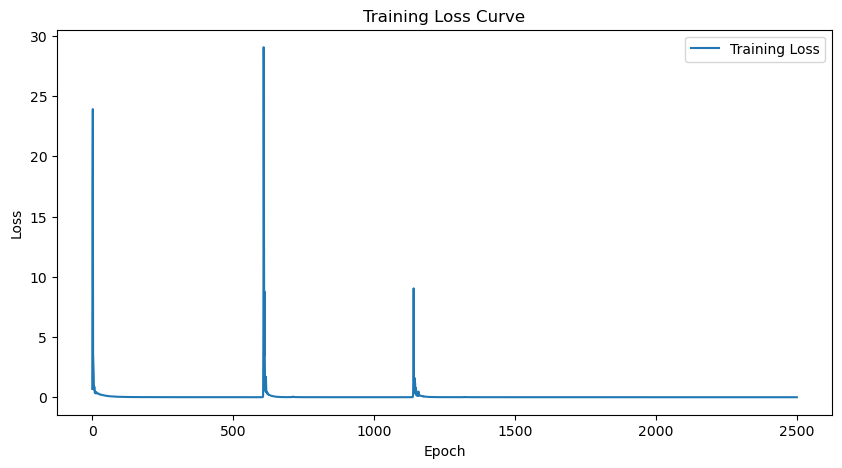

Final Model Accuracy: 95.41%
Final Model F1-score: 0.9557


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [11]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.95      0.95      0.95       147
non_infringement       0.96      0.96      0.96       158

        accuracy                           0.95       305
       macro avg       0.95      0.95      0.95       305
    weighted avg       0.95      0.95      0.95       305



/tmp/ipykernel_1715504/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
